# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [2]:
import sys

sys.path.append("../../resource/PiDiNet/pidinet-master")
sys.path.append("../../src")

import models
from dataset import BIPEDv2, transforms

# Prepare

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 100
batch_size = 8
learning_rate = 1e-4
# train set
biped_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/",
    return_map=False
)
# validation set
val_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/test/rgbr/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/",
    return_map=False
)

class Args:
    model = "pidinet_converted"
    config = "carv4"
    sa = True
    dil = True
args = Args()
model = getattr(models, args.model)(args)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=4)
val_loader = DataLoader(val_dataset, batch_size=4)
logging = {
    "metadata": {},
    'train_loss': [],
    'val_loss': []
}


print(device)

{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}
initialization done
cuda


# Train

In [ ]:
import os
# set checkpoint file name
file_stem = "cpt_PiDiNet_02"
logging['metadata'] = {
    "description": "Train without visibility map, only use edge map", 
    "num_epoch":epoch, 
    "batch_size":batch_size, 
    "criterion": criterion.__class__.__name__, 
    "learning_rate": learning_rate
}

if not os.path.isfile(f"./checkpoints/{file_stem}.json"): # First train
    model = model.to(device)
    for e in range(epoch):
        # train step
        model.train()
        epoche_loss = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
            loss.backward()
            optimizer.step()
            print("*", end="", flush=True)
            epoche_loss.append(loss.detach().item())
        logging['train_loss'].append(np.mean(epoche_loss))
        print(f"\nIn epoch {e}, the average  training  loss is {logging['train_loss'][-1]}")
        # validation step
        model.eval()
        val_epoch_loss = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
                val_epoch_loss.append(loss.detach().item())
        logging['val_loss'].append(np.mean(val_epoch_loss))
        print(f"\nIn epoch {e}, the average validation loss is {logging['val_loss'][-1]}")
    model = model.to('cpu')
    # save files
    # file_stem = "cpt_visibility_01"
    torch.save(model.state_dict(), f"./checkpoints/{file_stem}.pth")
    print(f"Succeed saving mdoel parameters in ./checkpoints/{file_stem}.pth.")
    with open(f"./checkpoints/{file_stem}.json", "w") as f:
        json.dump(logging, f)
    print(f"Succeed saving log in ./checkpoints/{file_stem}.json")
else: # already trained
    # load model
    model.load_state_dict(torch.load(f"./checkpoints/{file_stem}.pth", weights_only=True))
    # load log
    with open(f"./checkpoints/{file_stem}.json", 'r') as f:
        logging = json.load(f)
    # print the loss
    for e, (train_loss, val_loss) in enumerate(zip(logging['train_loss'], logging['val_loss'])):
        print("-".join(["-"]*30))
        print(f"\nIn epoch {e}, the average  training  loss is {train_loss}")
        print(f"\nIn epoch {e}, the average validation loss is {val_loss}")

**************************************************
In epoch 0, the average  training  loss is 156.0869596862793

In epoch 0, the average validation loss is 168.6911075298603
**************************************************
In epoch 1, the average  training  loss is 154.36463691711427

In epoch 1, the average validation loss is 166.62086310753455
**************************************************
In epoch 2, the average  training  loss is 152.70630165100098

In epoch 2, the average validation loss is 164.8539328941932
**************************************************
In epoch 3, the average  training  loss is 151.1753630065918

In epoch 3, the average validation loss is 163.38644409179688
**************************************************
In epoch 4, the average  training  loss is 150.13923583984376

In epoch 4, the average validation loss is 162.50678898737982
**************************************************
In epoch 5, the average  training  loss is 149.41192825317384

In epoch 5

# Resultat

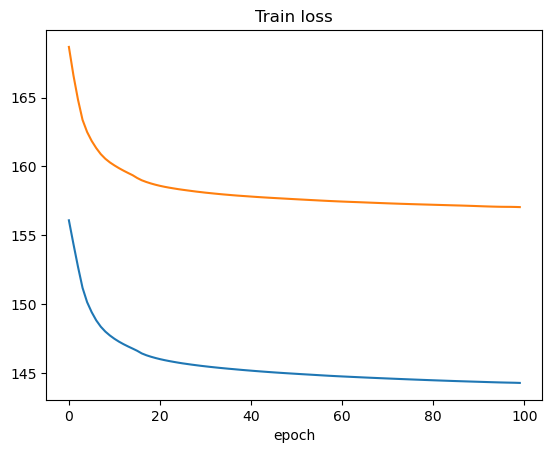

In [10]:
import json
import matplotlib.pyplot as plt

plt.plot(logging['train_loss'])
plt.plot(logging['val_loss'])
plt.title("Train loss")
plt.xlabel("epoch")
plt.show()

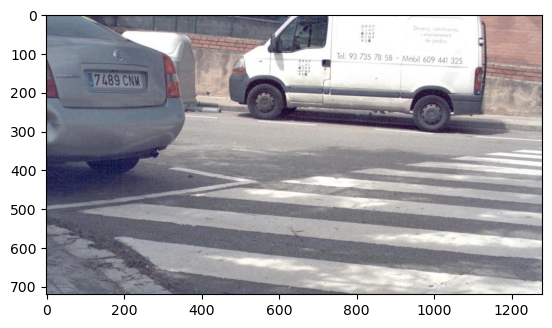

In [11]:
# take one example
x, y = biped_dataset[6]

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],  
    std=[1/s for s in std]
)


plt.imshow(denormalize(x).permute(1,2,0))
plt.show()

In [12]:
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

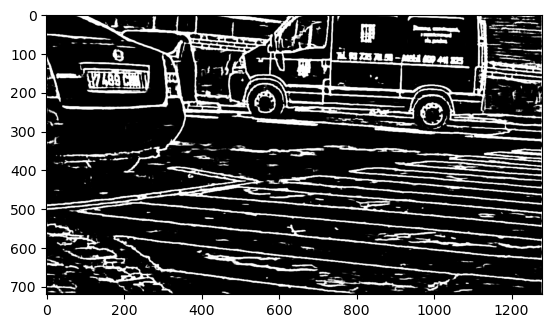

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def normalisation(img, percentile=95):
    res = img / np.percentile(img, percentile)
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res) 
    return res

plt.imshow(yhat, cmap="gray")
plt.show()

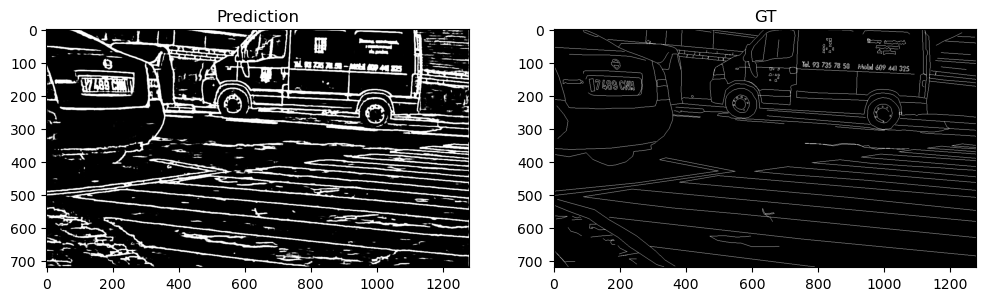

In [14]:
# display result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
# fig.suptitle(img_index)
ax1.imshow(normalisation(yhat, 98), cmap="gray")
ax1.set_title("Prediction")
ax2.imshow(normalisation(y, 98), cmap="gray")
ax2.set_title("GT")
plt.show()